In [1]:
from typing import Final

import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit, execute
from qiskit.circuit import Qubit
from qiskit.providers import Backend
from qiskit.tools.monitor import job_monitor

In [2]:
plt.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = "12"

In [3]:
NUM_SITES: Final[int] = 8

In [4]:
def digital_sum(n: int) -> int:
    """Sum the digits of a number.

    Args:
        n (int): Number to sum the digits of

    Returns:
        int: Sum of digits in number
    """
    return sum([int(i) for i in str(n)])

In [5]:
# Bogoliubov transformation


def thetak(k: int, lambda_: float) -> float:
    """Calculate a theta_k given k and lambda.

    Args:
        k (int): k value
        lambda_ (float): lambda value

    Returns:
        float: value of theta
    """
    angle = 2 * np.pi * k / NUM_SITES
    x = np.cos(angle)
    y = np.sin(angle)

    return np.arccos(-(lambda_ - x) / np.sqrt((lambda_ - x) ** 2 + y**2))


def bogo(qc: QuantumCircuit, qubits: list[Qubit], theta: float) -> None:
    """Apply the Bogoliubov gate to a quantum circuit.

    Args:
        qc (QuantumCircuit): Qiskit Quantum Circuit. This circuit will be modified in place.
        qubits (list[Qubit]): List of Qubits to apply the circuits to. Often obtained with circuit.qubits
        theta (float): Angle to rotate in the X-axis by the controlled RX gate
    """
    qc.x(qubits[1])
    qc.cx(qubits[1], qubits[0])
    qc.crx(theta, qubits[0], qubits[1])
    qc.cx(qubits[1], qubits[0])
    qc.x(qubits[1])

In [6]:
def disentangle(qc: QuantumCircuit, lambda_: float) -> None:
    """Apply the disentaglement gates to the quantum circuit.

    Args:
        qc (QuantumCircuit): Qiskit quantum circuit. This circuit will be modified in place.
        lambda_ (float): lambda value
    """
    from module.fswap import FSwapGate
    from module.ffft import FFFTGate

    # qc.append(FSwapGate(), [0, 1])
    # qc.append(FSwapGate(), [1, 2])

    # bogo(qc, qc.qubits[0:2], thetak(0, lambda_))
    bogo(qc, qc.qubits[2:4], thetak(2, lambda_))
    bogo(qc, qc.qubits[4:6], thetak(1, lambda_))
    bogo(qc, qc.qubits[6:8], thetak(3, lambda_))

    qc.append(FSwapGate(), [1, 2])
    qc.append(FFFTGate(0), [0, 1])
    qc.append(FFFTGate(0), [2, 3])
    qc.append(FSwapGate(), [1, 2])
    qc.append(FFFTGate(0), [0, 1])
    qc.append(FFFTGate(2), [2, 3])
    qc.append(FSwapGate(), [1, 2])

    qc.append(FSwapGate(), [5, 6])
    qc.append(FFFTGate(0), [4, 5])
    qc.append(FFFTGate(0), [6, 7])
    qc.append(FSwapGate(), [5, 6])
    qc.append(FFFTGate(0), [4, 5])
    qc.append(FFFTGate(2), [6, 7])
    qc.append(FSwapGate(), [5, 6])

    qc.append(FSwapGate(), [3, 4])
    qc.append(FSwapGate(), [2, 3])
    qc.append(FSwapGate(), [4, 5])
    qc.append(FSwapGate(), [1, 2])
    qc.append(FSwapGate(), [3, 4])
    qc.append(FSwapGate(), [5, 6])

    qc.append(FFFTGate(0), [0, 1])
    qc.append(FFFTGate(1), [2, 3])
    qc.append(FFFTGate(2), [4, 5])
    qc.append(FFFTGate(3), [6, 7])

    qc.append(FSwapGate(), [1, 2])
    qc.append(FSwapGate(), [3, 4])
    qc.append(FSwapGate(), [5, 6])
    qc.append(FSwapGate(), [2, 3])
    qc.append(FSwapGate(), [4, 5])
    qc.append(FSwapGate(), [3, 4])

In [7]:
def expected_magnetization(
    lambda_: float, backend: Backend, shots: int = 1024
) -> float:
    """Execute the passed in circuit as a job and return the expected magnetization.

    Args:
        lambda_ (float): lambda value
        backend (Backend): backend to run the job against
        shots (int): number of shots to run the job [Default: 1024]

    Return:
        float: magnetization result from job
    """
    qc = QuantumCircuit(NUM_SITES)

    # Set correct ground state for lambda < 1
    if lambda_ < 1:
        qc.x(NUM_SITES - 1)

    disentangle(qc, lambda_)
    qc.measure_all()

    job = execute(qc, backend=backend, shots=shots)
    job_monitor(job)

    counts = job.result().get_counts()

    c1 = list(counts.keys())
    c2 = list(counts.values())

    return sum([(1 - digital_sum(c1[j]) / 2) * c2[j] / shots for j in range(len(c1))])

In [8]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()
provider.backends()

[<IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>]

In [9]:
backend = provider.get_backend("ibmq_qasm_simulator")

In [14]:
def exact(lambda_: float) -> float:
    magnetization = lambda_ / (2 * np.sqrt(1 + lambda_**2))
    if lambda_ < 1:
        return magnetization
    if lambda_ > 1:
        return magnetization + 0.5
    return np.nan


vexact = np.vectorize(exact)

lambdas = np.linspace(0, 1.8, 10)
more_lambdas = np.linspace(0, 1.8, 301)

# TODO: fix this (negative / 2)
magnetization = [-expected_magnetization(l, backend)/2 for l in lambdas]

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


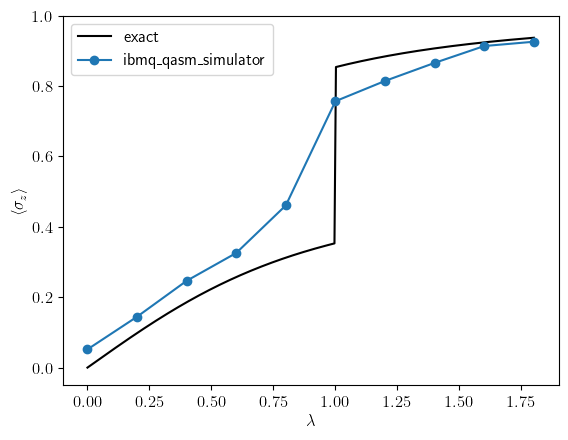

In [16]:
# Plot the magnetization values for the range of lambdas
fix, ax = plt.subplots()

ax.plot(more_lambdas, vexact(more_lambdas), color="black", label="exact")
ax.plot(lambdas, magnetization, marker="o", label=backend.name)

ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$\langle \sigma_{z} \rangle$")

ax.set_xlim(min(lambdas) - 0.1, max(lambdas) + 0.1)
ax.set_ylim(-0.05, 1)

ax.legend()

In [ ]:
def time_evolution(
    time: float, lambda_: float, backend: Backend, shots: int = 1024
) -> float:
    """Perform time evolution of the Ising Model.

    Args:
        time (float): time value to evolve over
        lambda_ (float): lambda value
        backend (Backend): name of the backend to run on
        shots (int): Number of shots to run the job [Default: 1024]

    Return:
        float: magnetization result
    """
    qc = QuantumCircuit(NUM_SITES)

    qc.u(
        np.arccos(lambda_ / np.sqrt(1 + lambda_**2)),
        np.pi / 2 + 4 * time * np.sqrt(1 + lambda_**2),
        0,
        0,
    )
    qc.cx(0, 1)

    disentangle(qc, lambda_)
    qc.measure_all()

    qc.draw(output="mpl")

    job = execute(qc, backend=backend, shots=shots)
    job_monitor(job)

    counts = job.result().get_counts()

    c1 = list(counts.keys())
    c2 = list(counts.values())

    return sum([(1 - digital_sum(c1[j]) / 2) * c2[j] / shots for j in range(len(c1))])

In [ ]:
def exact_time(time: float, lambda_: float) -> float:
    return (1 + 2 * lambda_**2 + np.cos(4 * time * np.sqrt(1 + lambda_**2))) / (
        2 + 2 * lambda_**2
    )


vexact_time = np.vectorize(exact_time)

times = np.linspace(0, 2, 9)
more_times = np.linspace(0, 2, 301)
lambdas = [0.5, 0.9, 1.8]

magnetization_time = [[time_evolution(t, l, backend) for t in times] for l in lambdas]

In [ ]:
fig, ax = plt.subplots()

cmap = plt.get_cmap("tab10")

for idl, l in enumerate(lambdas):
    ax.plot(
        more_times,
        vexact_time(more_times, l),
        color=cmap(idl),
        label="exact" if idl == 0 else None,
    )
    ax.plot(
        times,
        magnetization_time[idl],
        linestyle="--",
        marker="o",
        label=r"$\lambda = " + str(l) + "$",
    )

ax.set_xlabel("time")
ax.set_ylabel(r"$\langle \sigma_{z} \rangle$")

ax.set_xlim(min(times) - 0.1, max(times) + 0.1)
ax.set_ylim(0.1, 1.1)

ax.legend()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

cmap = plt.get_cmap("tab10")

for idl, l in enumerate(lambdas):
    ax[idl].plot(
        more_times,
        vexact_time(more_times, l),
        color=cmap(idl),
    )
    ax[idl].plot(
        times, magnetization_time[idl], color=cmap(idl), linestyle="--", marker="o"
    )

    ax[idl].set_title(r"$\lambda = " + str(l) + "$")

    ax[idl].set_xlabel("time")
    ax[idl].set_ylabel(r"$\langle \sigma_{z} \rangle$")

    ax[idl].set_xlim(min(times) - 0.1, max(times) + 0.1)
    ax[idl].set_ylim(
        0.1 if idl == 0 else 0.3 if idl == 1 else 0.75, 1.1 if idl != 2 else 1.05
    )

In [17]:
import qiskit.tools.jupyter

%qiskit_version_table